**Forecasting has the following stages:**



1.   Determining (p,d,q) values in ARIMA
2.   Forecasting with ARIMA
3.   Analyzing Residual Errors


---





#Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt

# 1. Determining (p,d,q) values in ARIMA

## Determining q value 


---

*ADF TEST : Augmented Dicky Fuller* - finds the differencing vale that removes Stationarity from the Data

H0 : Data is not Stationary
H1 : Data is Stationary

Reject the null hypothesis when ADF value is less than 1% critical value

In [2]:
series = pd.read_csv('/content/energydemand_training.csv', index_col=0, parse_dates=True, squeeze=True)
series1 = pd.read_csv('/content/MonthlyEnergyDemandData_training.csv', index_col=0, parse_dates=True, squeeze=True)
# series2 = pd.read_csv('/content/MonthlyEnergyDemandData_training2.csv', index_col=0, parse_dates=True, squeeze=True)

series4 = pd.read_csv('/content/YearlyEnergyDemandData_Training.csv', index_col=0, parse_dates=True, squeeze=True)

In [3]:
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [4]:
#No Differencing
from statsmodels.tsa.stattools import adfuller

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
# save
# stationary.to_csv('stationary.csv', header=False)

ADF Statistic: -4.792430
p-value: 0.000056
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [5]:
#1 differencing

def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return pd.Series(diff)

# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header=False)

ADF Statistic: -9.247085
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Since ADF statistic is less than 1% Critical Value for both 0 and 1 differencing, we can conclude that the data is not stationary

## Determining p value



---

Plotting Autocorrelation and Partial Autocorrelation plots:

### For Daily Data

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


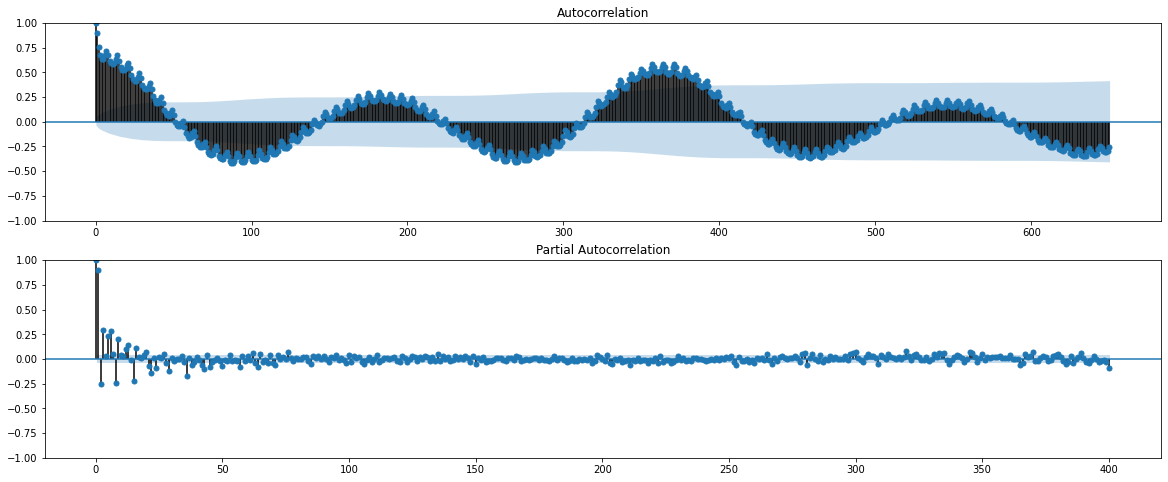

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(20,8))
plt.subplot(211)
plot_acf(series, lags=650, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, lags=400, ax=plt.gca())
plt.show()

Here we can see some correlation when p value is around 365

Also some inverse correlation is observed at 100 and 280

Let us now visualize using monthly data

### For Monthly Data

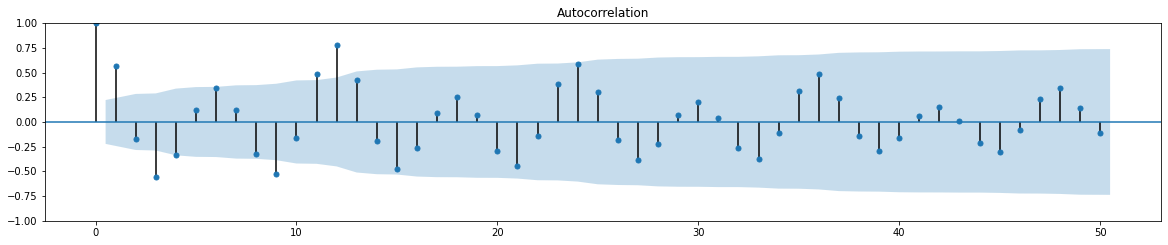

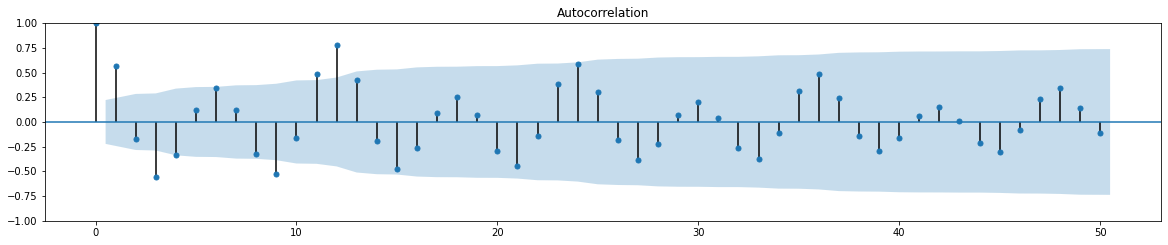

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(20,8))
plt.subplot(211)
plot_acf(series1, lags=50, ax=plt.gca())


At p = 3, some inverse correlation is observed

At p = 11 and 12, some positive correlation is seen

This shows that Today's demand is highly correlated with last year's demand on the same day.

### For Yearly Data

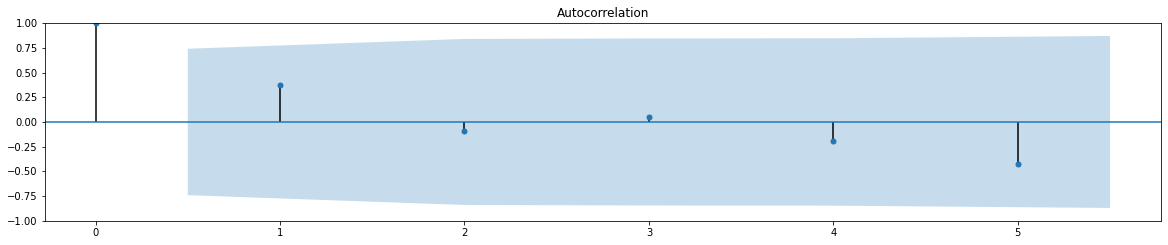

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(20,8))
plt.subplot(211)
plot_acf(series4, lags=5, ax=plt.gca())
plt.show()

This does not give much insight.

# Fitting the ARIMA model using (p,d,q) = (365,1,1):

In [12]:
pd.__version__


'1.3.5'

In [13]:
# ! pip install --upgrade statsmodels
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

#prepare data
X = series1.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)): 
  # predict
  model = ARIMA(history, order=(11,1,2))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=17540.643, Expected=16602.000
>Predicted=16851.861, Expected=17113.000
>Predicted=18156.767, Expected=17721.000
>Predicted=18323.296, Expected=18713.000
>Predicted=18749.343, Expected=18161.000
>Predicted=17580.835, Expected=17158.000
>Predicted=16284.706, Expected=15457.000
>Predicted=16394.268, Expected=15525.000
>Predicted=17479.370, Expected=17889.000
>Predicted=20256.968, Expected=22473.000
>Predicted=22307.366, Expected=20299.000
>Predicted=17679.787, Expected=17479.000
>Predicted=15892.062, Expected=15727.000
>Predicted=16817.923, Expected=16666.000
>Predicted=17396.815, Expected=17811.000
>Predicted=19014.291, Expected=17637.000
>Predicted=17479.341, Expected=17368.000
>Predicted=16154.389, Expected=15638.000
>Predicted=14917.525, Expected=14333.000
>Predicted=15222.182, Expected=14371.000
>Predicted=17338.671, Expected=17945.000
>Predicted=19571.146, Expected=22092.000
>Predicted=20875.512, Expected=20375.000
>Predicted=17441.400, Expected=16988.000
>Predicted=15745

In [16]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   77
Model:                ARIMA(11, 1, 2)   Log Likelihood                -620.640
Date:                Sun, 01 May 2022   AIC                           1269.280
Time:                        20:45:29   BIC                           1301.910
Sample:                             0   HQIC                          1282.321
                                 - 77                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5374      0.187      2.876      0.004       0.171       0.904
ar.L2         -0.7093      0.128     -5.537      0.000      -0.960      -0.458
ar.L3         -0.2741      0.193     -1.419      0.156      -0.653       0.104
ar.L4         -0.0133      0.194     -0.069      0.945      -0.394       0.367
ar.L5         -0.4821      0.156     -3.094      0.002      -0.787      -0.177
ar.L6         -0.0300      0.182     -0.165      0.869      -0.386       0.326
ar.L7         -0.2165      0.141     -1.532      0.125      -0.493       0.060
ar.L8         -0.2381      0.189     -1.259      0.208      -0.609       0.133
ar.L9         -0.1230      0.144     -0.856      0.392      -0.405       0.159
ar.L10        -0.2325      0.089     -2.626      0.009      -0.406      -0.059
ar.L11         0.1284      0.118      1.086      0.277      -0.103       0.360
ma.L1         -0.7864      0.166     -4.733      0.000      -1.112      -0.461
ma.L2          0.6324      0.107      5.922      0.000       0.423       0.842
sigma2      5.139e+05   9.91e+04      5.184      0.000     3.2e+05    7.08e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                14.43
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.98
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.08e+14. Standard errors may be unstable.
"""

In [22]:
model_fit.save('model.pkl')

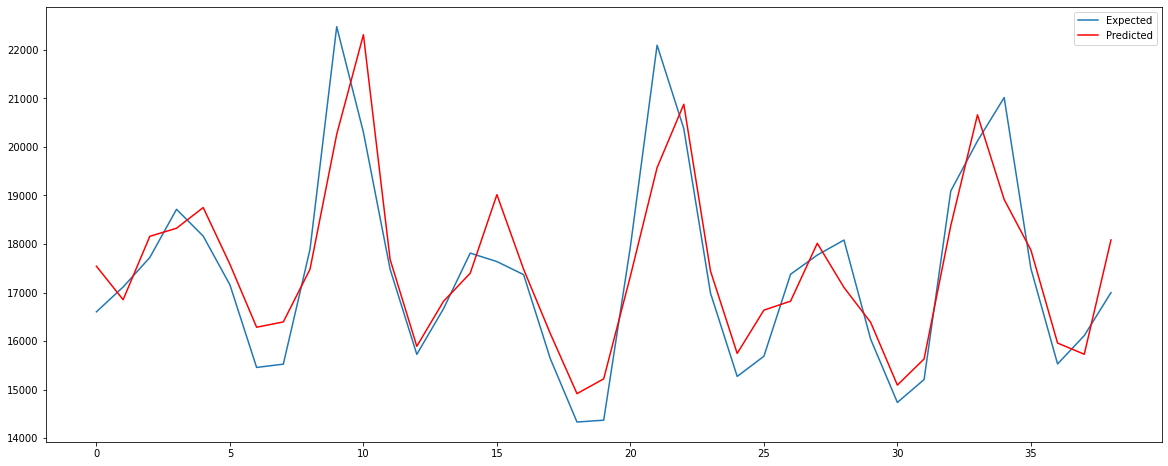

In [23]:

plt.figure(figsize=(20,8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['Expected','Predicted'])
plt.show()


In [ ]:
import warnings
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  X = X.astype('float32')
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0,13)
d_values = range(0,2)
q_values = range(0,3)
warnings.filterwarnings("ignore")
evaluate_models(series1.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=2100.405
ARIMA(0, 0, 1) RMSE=1604.901
ARIMA(0, 0, 2) RMSE=1389.511
ARIMA(0, 1, 0) RMSE=1976.228
ARIMA(0, 1, 1) RMSE=1837.103
ARIMA(0, 1, 2) RMSE=1752.323
ARIMA(1, 0, 0) RMSE=1766.944
ARIMA(1, 0, 1) RMSE=1539.972
ARIMA(1, 0, 2) RMSE=1404.426
ARIMA(1, 1, 0) RMSE=1901.346
ARIMA(1, 1, 1) RMSE=1836.758
ARIMA(1, 1, 2) RMSE=1565.228
ARIMA(2, 0, 0) RMSE=1267.243
ARIMA(2, 0, 1) RMSE=1280.505
ARIMA(2, 0, 2) RMSE=1265.496
ARIMA(2, 1, 0) RMSE=1600.002
ARIMA(2, 1, 1) RMSE=1376.459
ARIMA(2, 1, 2) RMSE=1170.736
ARIMA(3, 0, 0) RMSE=1280.362
ARIMA(3, 0, 1) RMSE=1292.272
ARIMA(3, 0, 2) RMSE=1310.432
ARIMA(3, 1, 0) RMSE=1395.406
ARIMA(3, 1, 1) RMSE=1385.604
ARIMA(3, 1, 2) RMSE=1337.325
ARIMA(4, 0, 0) RMSE=1267.210
ARIMA(4, 0, 1) RMSE=1306.967
ARIMA(4, 0, 2) RMSE=1297.363
ARIMA(4, 1, 0) RMSE=1386.899
ARIMA(4, 1, 1) RMSE=1342.604
ARIMA(4, 1, 2) RMSE=1364.597
ARIMA(5, 0, 0) RMSE=1276.838
ARIMA(5, 0, 1) RMSE=1297.017
ARIMA(5, 0, 2) RMSE=1303.773
ARIMA(5, 1, 0) RMSE=1363.734
ARIMA(5, 1, 1)